<a href="https://colab.research.google.com/github/jaremy-k/tg_human_detect_bot/blob/master/NEW_v2_%22ResNet_18_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%BD%D0%B8%D0%B5_%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D0%BA%D0%B0_%D0%BD%D0%B0_%D1%84%D0%BE%D1%82%D0%BE_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предварительная настройка

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
import random

In [ ]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

# Датасет

**image loaders** https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**data loaders** https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
NAME='Humans_video'

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(1080),
#        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(1080),
#        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/My Drive/AI/'+NAME
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


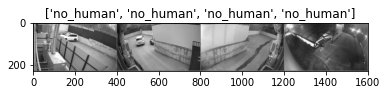

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = []; 
    hist_loss_val = []; hist_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc)
            else:     
                hist_loss_val.append(epoch_loss)
                hist_acc_val.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    model.eval()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best epoch:{} val Loss:{:4f} Acc: {:4f}'.format(best_epoch,best_loss,best_acc))

    plt.plot(np.arange(0,num_epochs),hist_loss_train,label='hist_loss_train')
    plt.plot(np.arange(0,num_epochs),hist_loss_val,label='hist_loss_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Loss')
    plt.show()
    plt.plot(np.arange(0,num_epochs),hist_acc_train,label='hist_acc_train')
    plt.plot(np.arange(0,num_epochs),hist_acc_val,label='hist_acc_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Acc')
    plt.show()


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            t0 = time.time()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print("Время инфренса батча(мс): {:4f}".format((time.time()-t0)*1000))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
  param.requires_grad = False
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.2829 Acc: 0.8930
val Loss: 0.3261 Acc: 0.8882

Epoch 1/24
----------
train Loss: 0.2287 Acc: 0.9128
val Loss: 0.3849 Acc: 0.8917

Epoch 2/24
----------
train Loss: 0.2075 Acc: 0.9222
val Loss: 0.3573 Acc: 0.9068

Epoch 3/24
----------
train Loss: 0.1949 Acc: 0.9274
val Loss: 0.2787 Acc: 0.9158

Epoch 4/24
----------
train Loss: 0.1626 Acc: 0.9392
val Loss: 0.2792 Acc: 0.9083

Epoch 5/24
----------
train Loss: 0.1765 Acc: 0.9342
val Loss: 0.3444 Acc: 0.9058

Epoch 6/24
----------
train Loss: 0.1621 Acc: 0.9395
val Loss: 0.3710 Acc: 0.9118

Epoch 7/24
----------
train Loss: 0.1085 Acc: 0.9614
val Loss: 0.3402 Acc: 0.9124

Epoch 8/24
----------
train Loss: 0.1038 Acc: 0.9615
val Loss: 0.2920 Acc: 0.9266

Epoch 9/24
----------
train Loss: 0.1014 Acc: 0.9621
val Loss: 0.3417 Acc: 0.9131

Epoch 10/24
----------
train Loss: 0.0979 Acc: 0.9646
val Loss: 0.2778 Acc: 0.9166

Epoch 11/24
----------
train Loss: 0.1049 Acc: 0.9627
val Loss: 0.3164 Acc: 0.9174

Epoch 12/24
----------
t

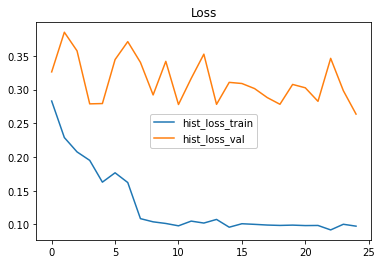

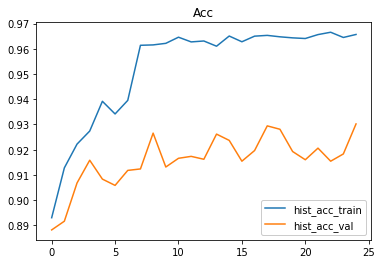

--- 11244.301937103271 seconds ---


In [ ]:
import time
start_time = time.time()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
print("--- %s seconds ---" % (time.time() - start_time))

Время инфренса батча(мс): 6.266594


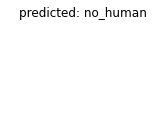

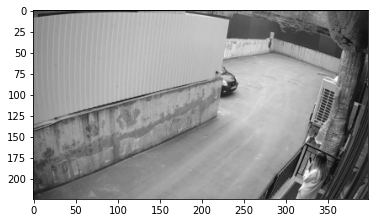

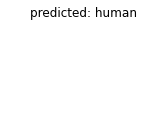

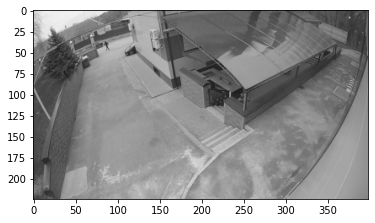

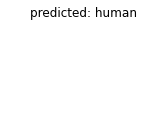

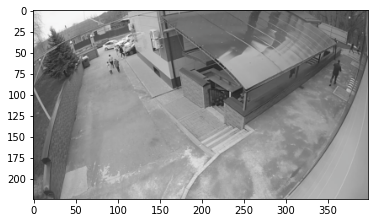

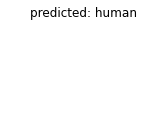

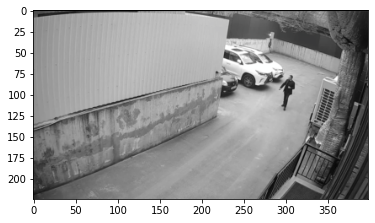

In [ ]:
visualize_model(model_ft.to(device),num_images=4)

[[2335   97]
 [ 267 2516]]


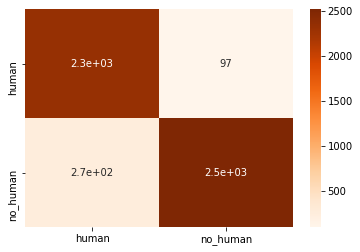

In [ ]:
true_labels=[]
pred_labels=[]
for inputs, labels in dataloaders['val']:
  pred = model_ft.forward(inputs.to(device))
  _, pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
from pandas import DataFrame
import seaborn as sn
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

In [ ]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model_ft.eval()
model_ft=model_ft.to(torch.device("cpu"))
#model_ft=torch.quantization.convert(model_ft)
#torch.jit.script(model_ft).save("/content/drive/My Drive/AI/Samsung/fire_net.pt")
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model_ft,input_tensor)
script_model.save("/content/drive/My Drive/AI/Nerual/"+NAME+".pt")

In [ ]:
!nvidia-smi

Wed Jun 30 02:11:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |   1131MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun 30 02:11:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |   1131MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------